# K Nearest Neighbor with Dynamic Time Warping

In [8]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

In [9]:
plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

In [10]:
class KnnDtw(object):
    # n_neighbors : Number of neighbors to use by default for KNN (default = 5)
    # max_warping_window : It is allowed by DTW dynamic programming function (default = infinity)
    # subsample_step : Step size for the time series array (default = 1)
    
    def __init__(self, n_neighbors = 5, max_warping_window = 10000, subsample_step = 1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    # Fit the model using x as training data and l as class labels
    def fit(self, x, l):
        self.x = x
        self.l = l
    
    # Returns the DTW similarity distance between two 2D time series numpy arrays
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M,N))
        
        # Initialize the first row and column
        cost[0,0] = d(ts_a[0], ts_b[0])
        for i in range(1,M):
            cost[i,0] = cost[i-1,0] + d(ts_a[i], ts_b[0])
        for j in range(1,N):
            cost[0,j] = cost[0,j-1] + d(ts_a[0], ts_b[j])
        
        # Populate rest of cost matrix within window
        for i in range(1,M):
            for j in range(max(1, i - self.max_warping_window),
                          min(N, i + self.max_warping_window)):
                choices  = cost[i-1, j-1], cost[i, j-1], cost[i-1, j]
                cost[i,j] = min(choices) + d(ts_a[i], ts_b[j])
        
        # Returns DTW distance given window
        return cost[-1,-1]
    
    # Compute the M x N distance matrix between the training dataset and testing dataset(y)
    # using the DTW distance measure
    def _dist_matrix(self, x, y):
        dm_count = 0
        
        # Compute condensed distance matrix of pairwise dtw distances when x and y are the same array
        if np.array_equal(x,y):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype = np.double)
            
            P = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                y[j, ::self.subsample_step])
                    dm_count += 1
                    p.animate(dm_count)
             
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distance between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0] * y_s[0]
            
            p = ProgressBar(dm_size)
            
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i,j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                y[j, ::self.subsample_step])
                    dm_count += 1
                    p.animate(dm_count)
                    
            return dm
        
    # Predict the class labels or probability estimates for the provided data
    def predict(self, x):
        dm = self._dist_matrix(x, self.x)
        
        knn_idx = dm.argsort()[:, :self.n_neighbors]
        knn_labels = self.l[knn_idx]
        
        mode_data = mode(knn_labels, aixs=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1] / self.n_neighbors
        
        return mode_label.ravelvel(), mode_proba.ravel()           

In [11]:
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython
            
    def animate_ipython(self, iter):
        print ('\r', self,
        sys.stdout.flush())
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar) 

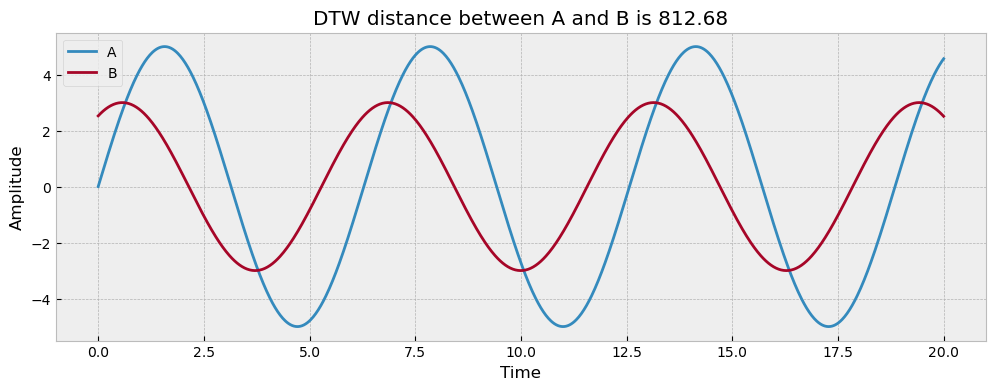

In [12]:
time = np.linspace(0, 20, 1000)
amplitude_a = 5 * np.sin(time)
amplitude_b = 3 * np.sin(time + 1)

m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)

fig = plt.figure(figsize=(12,4))
plt.plot(time, amplitude_a, label = 'A')
plt.plot(time, amplitude_b, label = 'B')
plt.title('DTW distance between A and B is %.2f' % distance)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.legend()

In [13]:
m._dist_matrix(np.random.randn(4,50), np.random.randn(4,50))

 [                  0%                  ] None
 [*****            12%                  ]  2 of 16 complete None
 [*******          19%                  ]  3 of 16 complete None
 [**********       25%                  ]  4 of 16 complete None
 [************     31%                  ]  5 of 16 complete None
 [**************   38%                  ]  6 of 16 complete None
 [*****************44%                  ]  7 of 16 complete None
 [*****************50%                  ]  8 of 16 complete None
 [*****************56%*                 ]  9 of 16 complete None
 [*****************62%****              ]  10 of 16 complete None
 [*****************69%******            ]  11 of 16 complete None
 [*****************75%********          ]  12 of 16 complete None
 [*****************81%***********       ]  13 of 16 complete None
 [*****************88%*************     ]  14 of 16 complete None
 [*****************94%****************  ]  15 of 16 complete None
 [****************100%***************

array([[30.44595605, 35.23882629, 34.14112597, 31.24156785],
       [31.5701309 , 34.97888321, 31.26756235, 35.3262049 ],
       [36.22188615, 36.61299023, 34.10755552, 34.04700704],
       [30.73654797, 35.41665942, 34.87340854, 36.5853573 ]])

In [14]:
# Import the HAR dataset
x_train_file = open('./Data/train/X_train.txt', 'r')
y_train_file = open('./Data/train/y_train.txt', 'r')

x_test_file = open('./Data/test/X_test.txt', 'r')
y_test_file = open('./Data/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

FileNotFoundError: [Errno 2] No such file or directory: './Data/train/X_train.txt'

In [ ]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([0,27,65,100,145,172]):
    plt.subplot(3,2,i+1)
    plt.plot(x_train[r][:100], label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('Samples @50Hz')
    plt.legend(loc='upper left')
    plt.tight_layout()